In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
import sys
sys.path.append('../')

import time
import numpy as np
from math import sqrt
from utils import paras
import sys
import os
import pickle
import argparse
import numpy as np
from env import *
from algo import *
from utils import Logger
from bandit_algo import *
import matplotlib.pyplot as plt

In [4]:
eps = 1e-5

In [5]:
class SCO_batch_env:
    def __init__(self, params):
        paras(self, params)
        self.random_seed = params['env']['random_seed']
        self.x_std = params['env']['x_std']
        self.y_std = params['env']['y_std']
        self.algo = params['algo']['type']
        self.p = params['env']['p']
        if np.isinf(self.p):
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)
        self.logger = params['logger']
    
    def run(self):
        # init theta
        theta = np.zeros(shape = self.size_SCO)
        theta[:self.s] = 1
        theta /= np.linalg.norm(theta.flatten(), self.p)
        
        X = np.random.normal(0, self.x_std, size = (self.T, self.d))
        X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        noise = np.random.normal(0, self.y_std, size=(self.T, 1))
        y = X.dot(theta) + noise
        S = np.hstack((X,y))
        self.theta_hat = self.algo.train(S, theta, self.logger)


In [6]:
class Algo(object):
    def __init__(self, params):
        paras(self, params)

    def update(self, theta0, theta1, x, y):
        pass

    def train(self,theta):
        self.start_time = time.time()
        X = np.random.normal(0, self.x_std, size=(self.test_size, self.d))
        self.X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        self.y = self.X.dot(theta) + np.random.normal(0, self.y_std, size=(self.test_size, 1))
        self.baseline = ((self.X.dot(np.zeros(self.size_SCO)) - self.y) ** 2).sum() / self.test_size
        self.opt_risk = ((self.X.dot(theta) - self.y) ** 2).sum() / self.test_size
        self.logger.record('baseline', self.baseline)

    def test(self, t, theta_hat):
        self.risk = ((self.X.dot(theta_hat) - self.y) ** 2).sum() / self.test_size
        self.subopt = (self.risk - self.opt_risk)/(self.baseline-self.opt_risk)
        self.logger.record('record', [t, self.risk, self.subopt])

In [7]:
class NoisySGD(Algo):
    '''
    Algorithm 2 in Stability of Stochastic Gradient Descent on Nonsmooth Convex Losses for 2<p<=infty
    Learning rate should be <=1. Be careful, the noise is in scaling of learning rate
    '''
    def __init__(self, params):
        paras(self, params)
        self.random_seed = params['env']['random_seed']
        self.kappa = min(1/(self.d-1), 2*log(self.d)) 
        self.p = params['env']['p']
        if np.isinf(self.p):
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)
        
    def train(self, S, theta, logger):
        self.logger = logger
        super().train(theta)
        r = np.linalg.norm(theta.flatten(), self.p)
        n = S.shape[0]
        sigma = sqrt(8*self.L0**2*log(1/self.delta)/self.eps**2)
        theta1 = np.zeros(shape = (self.d, 1))
        theta_list = list()
        if self.noise_free: 
            noise_mechanism = functools.partial(int, 0)
        else:
            noise_mechanism = functools.partial(np.random.normal, loc = 0, scale = sigma, size = (self.d, 1))

        if self.p < np.inf:
            proj = functools.partial(lp_projection, r = 2*r,  p = self.p)
        else:
            proj = functools.partial(Proj_inf, r = r)

        # initial time
        self.logger.record('time', time.time())
        indices = np.random.choice(n, n**2)
        GGNoises = [noise_mechanism() for _ in range(n**2-1)]
        X = S[:, :-1]
        Y = S[:, -1]
        for t in range(n**2-1):
            i = indices[t]
            GGNoise = GGNoises[t]
            etat = r/(self.L0*n*max(sqrt(n), sqrt(self.d*log(1/self.delta))/self.eps))*self.lr_scale
            theta1 = proj(theta1 - etat*(clip(compute_linear_gradient(theta1, X[i].reshape((-1, 1)), Y[i]).reshape((-1, 1)), self.L0, self.q) + GGNoise))
            theta_list.append(theta1)
            if t%(n**2//self.test_freq)==0:
                self.test(t, theta1)

        self.logger.record('time', time.time() - self.logger.dict['time'][0])
        return np.mean(theta_list, axis = 0)

In [11]:
def generate_params(algo, seed, p, d = 5, T = int(1e2), scale = 1, lip=1, noise_free = False, test_flag = False
):  
    params = dict()
    params['env'] = {"random_seed": seed,
                     "T": T,
                     "d": d,
                     "s": 5,  
                     "k": 5,
                     "p": p, 
                     "x_std": 0.05,
                     "y_std": 0.05,
                     "test_size": 1000, 
                     "test_freq" : T,
                     "lip": lip,
                     }

    np.random.seed(seed)
    
    logger = Logger()
    params['prv'] = {"eps": 1,
                     "delta": 1/params['env']['T']}
    params['logger'] = logger
    params['algo'] = dict()
    params['algo']['lr_scale'] = scale
    params['algo']['noise_free'] = noise_free
    params['algo']['test_flag'] = test_flag
    params['bandit'] = dict()
    if algo == 'OFW_ple2':
        params['algo']['type'] = OFW_ple2(params)
        env = SCO_steam_env(params)
    elif algo == 'OFW_pge2':
        params['algo']['type'] = OFW_pge2(params)
        env = SCO_steam_env(params)
    elif algo == 'Local_MD':
        params['algo']['type'] = Local_MD(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySFW':
        params['algo']['type'] = NoisySFW(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySGD':
        params['algo']['type'] = NoisySGD(params)
        env = SCO_batch_env(params)
    elif algo=='DPUCB':
        params['algo']['type'] = DPUCB(params)
        params['bandit']['multi'] = False
        env = bandits_env(params)
    elif algo=='OFW_peq1':
        params['algo']['type'] = OFW_peq1(params)
        params['bandit']['multi'] = True
        env = bandits_env(params)
        
    env.run()
    params['result'] = env.logger.dict
    return p, d, T, algo, str(scale), str(noise_free), str(test_flag), params

In [12]:
seed = 1
p = np.inf
T = 5000
d = 5
eta_scaling = 1
lip = 1
test_flag = True
noise_free = False
p, d, T, algo, scale, noise_free, test_flag, params  = generate_params('NoisySGD', seed=seed, p=p, d=d, T=T, scale=eta_scaling,
                                                                      noise_free = noise_free, lip=lip, test_flag = test_flag)


f, axs = plt.subplots(1, 2, figsize=(12,4))
risk = [r[1] for r in params['result']['record']]
axs[0].plot(risk)
axs[0].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last risk: {:.4f} -- min risk {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][1],
    min(risk),
))
axs[0].hlines(params['result']['baseline'][0], 0, len(risk), 'r')
axs[0].set_ylabel('risk', fontsize=20)

subopt = [r[2] for r in params['result']['record']]
axs[1].plot(subopt)
axs[1].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last subopt: {:.4f} -- min subopt {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][2],
    min(subopt),
))
axs[1].hlines(1, 0, len(risk), 'r')
axs[1].set_ylabel('subopt', fontsize=20)

plt.show()

KeyboardInterrupt: 

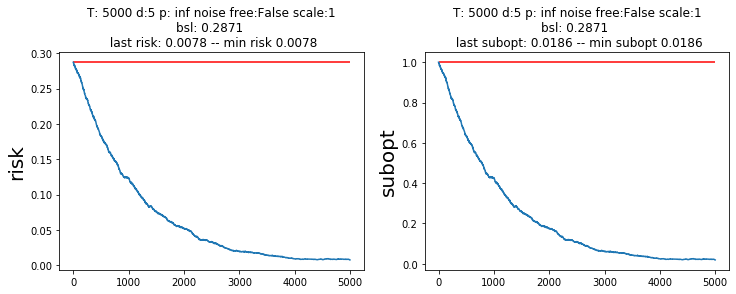

In [8]:
seed = 1
p = np.inf
T = 5000
d = 5
eta_scaling = 1
noise_norm = 1
test_flag = True
noise_free = False
p, d, T, algo, scale, noise_free, test_flag, params  = generate_params('NoisySGD', seed=seed, p=p, d=d, T=T, scale=eta_scaling,
                                                                      noise_free = noise_free, noise_norm=noise_norm, test_flag = test_flag)


f, axs = plt.subplots(1, 2, figsize=(12,4))
risk = [r[1] for r in params['result']['record']]
axs[0].plot(risk)
axs[0].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last risk: {:.4f} -- min risk {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][1],
    min(risk),
))
axs[0].hlines(params['result']['baseline'][0], 0, len(risk), 'r')
axs[0].set_ylabel('risk', fontsize=20)

subopt = [r[2] for r in params['result']['record']]
axs[1].plot(subopt)
axs[1].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last subopt: {:.4f} -- min subopt {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][2],
    min(subopt),
))
axs[1].hlines(1, 0, len(risk), 'r')
axs[1].set_ylabel('subopt', fontsize=20)

plt.show()